# Air transportation Ocurrences
## Summary Analysis 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../scripts")

In [4]:
from data_loader import load_data_from_csv, load_data_from_results
from common.export_csv import exportDataVersion
from common.export_result import export_csv_result
from common.export_temp_csv import export_csv_temp

In [5]:
df = load_data_from_csv('fullData_V2.csv')
#Data length
print(f"# of rows 'fullData_V2.csv': {len(df)}")

# of rows 'fullData_V2.csv': 47781


## Preprocessing

In [7]:
#Delete the rows without Summary
df = df.dropna(subset=['Summary']).reset_index(drop=True)

In [8]:
print(df['Summary'].head(10))

0    C-IICE a privately operated Quad City Challeng...
1    C-GWCP a Piper PA-32-300 aircraft operated by ...
2    C-FKCK an Airbus 320-200 aircraft operated by ...
3    C-GJVC a Fairchild SA227-DC aircraft operated ...
4    C-GGSV an Aerospatiale AS 350 B-2 aircraft ope...
5    N12028 an Airbus 319-100 aircraft operated by ...
6    C-GGCT a privately operated Cessna 182M aircra...
7    N910XJ a Bombardier CL-600-2D24 (CRJ 900) airc...
8    N174DZ a Boeing 767-300 aircraft operated by D...
9    C-FBIY a Cessna 182F aircraft operated by Skyd...
Name: Summary, dtype: object


### Deleting the first word
First word is a code, is not apporting value 

In [10]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk import download

Download necessary libaries

In [12]:
# import nltk
# import os

# # Define the path to download nltk data inside the venv
# nltk_data_path = os.path.join(os.getcwd(), "venv", "nltk_data")
# nltk.download('punkt', download_dir=nltk_data_path)
# nltk.download('stopwords', download_dir=nltk_data_path)
# nltk.download('punkt_tab')
# download('stopwords')  # Stopwords list
# download('punkt')      # Tokenizer
# nltk.download('punkt')
# print("NLTK data downloaded to:", nltk_data_path)

In [13]:
#Ensuring there are no spaces initially and in the end
df['Summary'] = df['Summary'].str.strip()

#Deleting the first word
df['Summary'] = df['Summary'].apply(lambda x: ' '.join(x.split(' ')[1:]) if isinstance(x, str) else x)

print(df['Summary'].head(10))

0    a privately operated Quad City Challenger II S...
1    a Piper PA-32-300 aircraft operated by MHA Ent...
2    an Airbus 320-200 aircraft operated by Air Can...
3    a Fairchild SA227-DC aircraft operated by Bear...
4    an Aerospatiale AS 350 B-2 aircraft operated b...
5    an Airbus 319-100 aircraft operated by America...
6    a privately operated Cessna 182M aircraft was ...
7    a Bombardier CL-600-2D24 (CRJ 900) aircraft op...
8    a Boeing 767-300 aircraft operated by Delta Ai...
9    a Cessna 182F aircraft operated by Skydive Man...
Name: Summary, dtype: object


In [14]:
#Preprocessing function
def preprocess_text(text):
    if pd.isnull(text):  # Handle null values
        return ""
    
    #Convert text to lowercase
    text = text.lower()
    
    #Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    #Remove numbers
    text = re.sub(r'\d+', '', text)
    
    #Tokenize the text into individual words
    words = word_tokenize(text)
    
    #Remove stopwords (common words like "a", "the", "is")
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    #Apply stemming (reduce words to their root form)
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    #Rejoin words into a single string and remove extra whitespace
    text = ' '.join(words).strip()
    
    return text

In [15]:
#Applying preprocessing to the "Summary" column
#df['Processed_Summary'] = df['Summary'].apply(preprocess_text)
#export_csv_result(df, "fullData_V2_summary_preprocessed")

In [16]:
df = load_data_from_results("fullData_V2_summary_preprocessed.csv")
#Data length
print(f"# of rows 'fullData_V2.csv': {len(df)}")

# of rows 'fullData_V2.csv': 47684


In [17]:
#Printing the DataFrame to see the results
print(df['Processed_Summary'].head(10))

0    privat oper quad citi challeng ii special adva...
1    piper pa aircraft oper mha enterpris conduct v...
2    airbu aircraft oper air canada conduct flight ...
3    fairchild sadc aircraft oper bearskin lake air...
4    aerospatial b aircraft oper great slave helico...
5    airbu aircraft oper american airlin conduct fl...
6    privat oper cessna aircraft conduct flight dir...
7    bombardi cld crj aircraft oper endeavour air c...
8    boe aircraft oper delta airlin conduct flight ...
9    cessna f aircraft oper skydiv manitoba conduct...
Name: Processed_Summary, dtype: object


### Frequency document-term matrix and word clouds

In [19]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
def get_words_frequencies(df_param):
    #Creating a document-term matrix
    vectorizer = CountVectorizer()
    dtm = vectorizer.fit_transform(df_param['Processed_Summary'])
    
    #Suming up the word counts
    word_counts = dtm.toarray().sum(axis=0)
    word_frequencies = pd.DataFrame({
        "word": vectorizer.get_feature_names_out(),
        "frequency": word_counts
    }).sort_values(by="frequency", ascending=False)

    return word_frequencies

In [21]:
def plotWordCloud(word_frequencies_param):
    #Converting the word_frequencies DataFrame to a dictionary
    word_frequencies_dict = dict(zip(word_frequencies_param["word"], word_frequencies_param["frequency"]))
    
    #Generating the Word Cloud
    wordcloud = WordCloud(
        width=800,               # Width of the Word Cloud image
        height=400,              # Height of the Word Cloud image
        background_color="white", # Background color
        colormap="viridis",      # Color palette
        max_words=200            # Maximum number of words to display
    ).generate_from_frequencies(word_frequencies_dict)
    
    #Plotting the Word Cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")  # Turn off axis
    plt.title("Word Cloud of Processed Summary", fontsize=16)
    plt.show()

#### For accidents

In [23]:
#Getting only accidents
df_filtered_accidents = df[df["OccTypeID_DisplayEng"] == "ACCIDENT"]

word_frequencies_accidents = get_words_frequencies(df_filtered_accidents)
#export_csv_result(word_frequencies_accidents, "Summary_word_frecuencies_ACCIDENTS")

#Display the first 10 rows
print(word_frequencies_accidents.head(10))

           word  frequency
510    aircraft      50648
19838     pilot      42471
15870      land      24824
12121    flight      14708
11106     engin      14051
21947    runway      13115
16070      left      10984
12861      gear       9962
21599     right       9718
9633      damag       9167


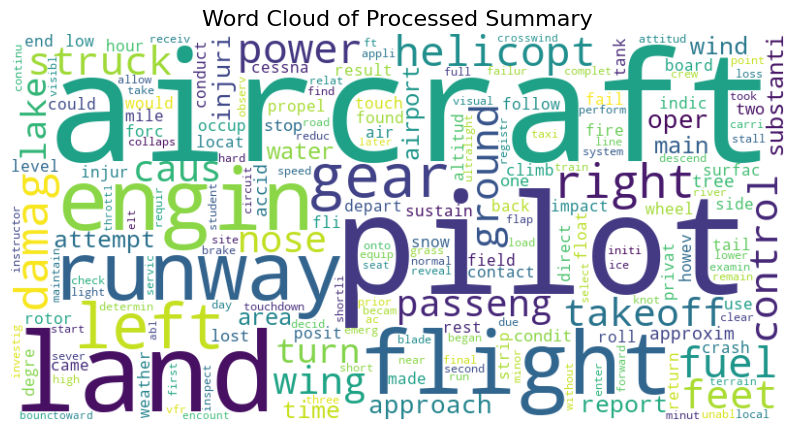

In [24]:
plotWordCloud(word_frequencies_accidents)

#### For incidents

In [26]:
#Filtering the DataFrame to keep only INCIDENT rows and drop NaN values in 'Processed_Summary'
df_filtered_incidents = df[df["OccTypeID_DisplayEng"] == "INCIDENT"].dropna(subset=['Processed_Summary'])

word_frequencies_incidents = get_words_frequencies(df_filtered_incidents)
#Exporting results
#export_csv_result(word_frequencies_incidents, "Summary_word_frequencies_INCIDENTS")

# Display the first few rows
print(word_frequencies_incidents.head(10))

           word  frequency
640    aircraft      43862
12623    flight      42013
8538       crew      32486
16841      land      25072
11360     engin      18379
20564      oper      17745
24176    runway      12920
607         air      12706
23721    return      11999
18048   mainten      10637


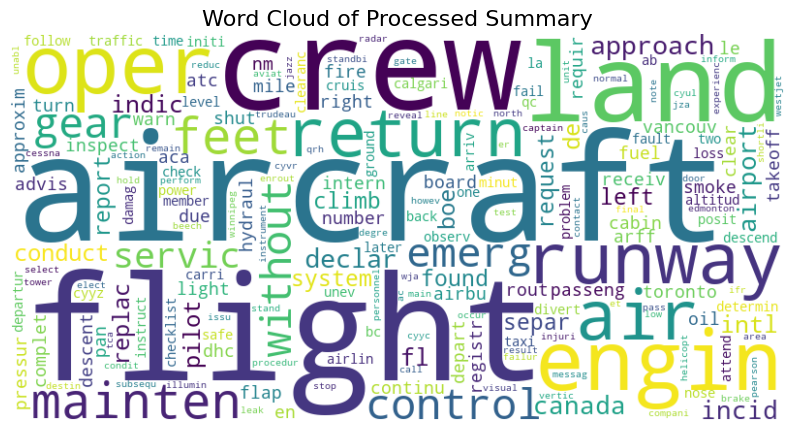

In [27]:
plotWordCloud(word_frequencies_incidents)

## Classification Model

In [29]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

In [30]:
NUMBER_OF_CLUSTERS = 4

In [31]:
#Function to preprocess and cluster data using TF-IDF + K-Means
def tfidf_kmeans_clustering(df_param, text_column):
    #Converting text into TF-IDF vectors
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(df_param[text_column])
    
    #Using the Elbow Method to find the optimal number of clusters
    distortions = []
    silhouette_scores = []
    K = range(2, 10)  
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(tfidf_matrix)
        distortions.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(tfidf_matrix, kmeans.labels_))

    #Plotting the elbow curve
    plt.figure(figsize=(12, 6))
    plt.plot(K, distortions, marker='o')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.show()

    #Plotting silhouette scores
    plt.figure(figsize=(12, 6))
    plt.plot(K, silhouette_scores, marker='o')
    plt.title('Silhouette Scores for K')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

    #Applying K-Means with the optimal number of clusters (manually choose or auto)
    optimal_k = NUMBER_OF_CLUSTERS
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    df_param.loc[:, "KMeansCluster"] = kmeans.fit_predict(tfidf_matrix)

    return df_param


In [32]:
def visualize_kmeans_clusters(df, tfidf_matrix, title="TF-IDF + K-Means Clustering"):
    #Reducing dimensions to 2D using PCA
    pca = PCA(n_components=2, random_state=42)
    reduced_data = pca.fit_transform(tfidf_matrix.toarray())

    #Creating a DataFrame for visualization
    vis_df = pd.DataFrame({
        "PCA1": reduced_data[:, 0],
        "PCA2": reduced_data[:, 1],
        "Cluster": df["KMeansCluster"]
    })

    # Plot the clusters
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=vis_df, x="PCA1", y="PCA2", hue="Cluster", palette="tab10", s=100)
    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

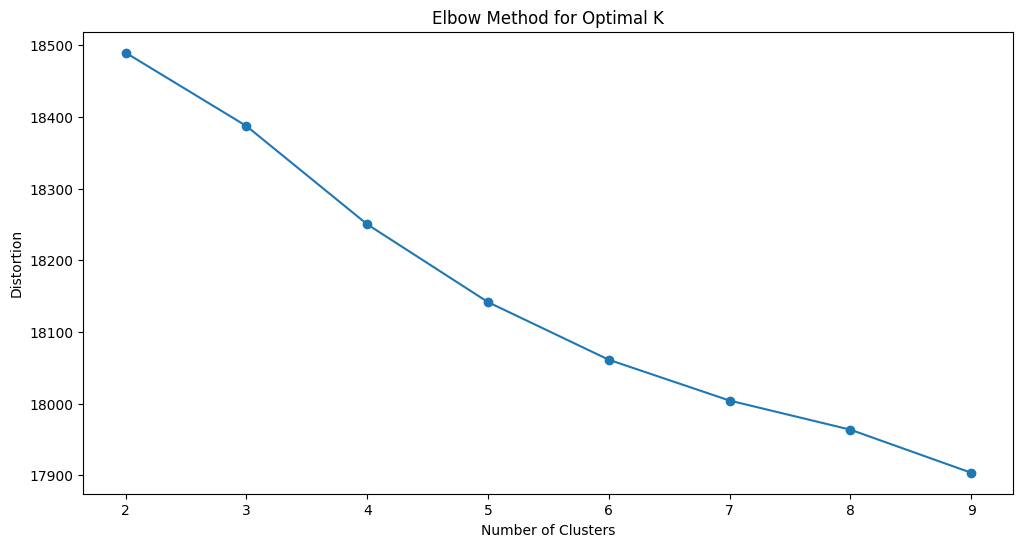

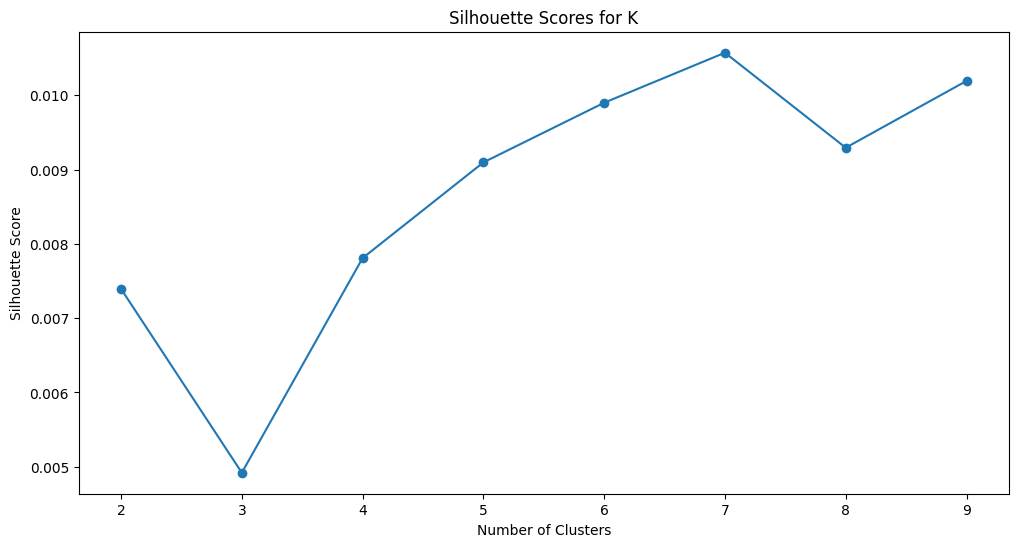

C:\Users\camii\AppData\Local\Temp\ipykernel_16600\3679190100.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_param["KMeansCluster"] = kmeans.fit_predict(tfidf_matrix)


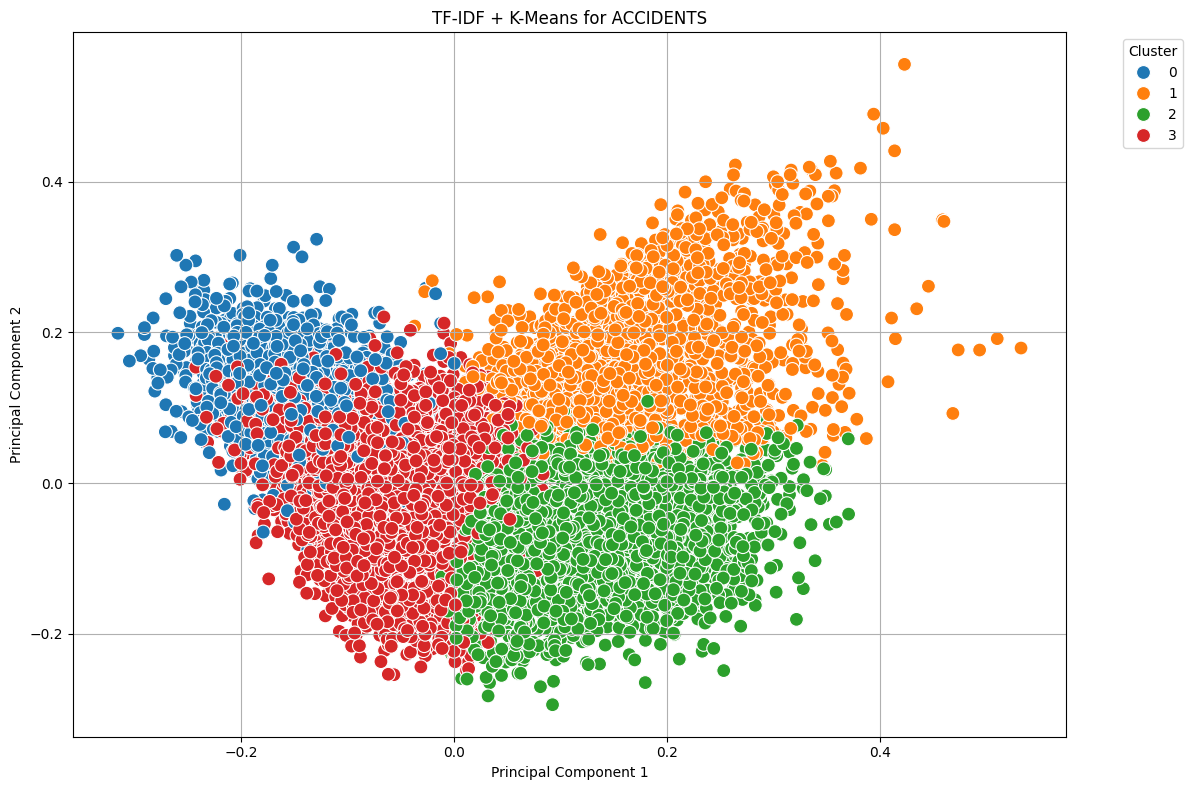

In [33]:
#Applying to ACCIDENTS
df_filtered_accidents = tfidf_kmeans_clustering(df_filtered_accidents, "Processed_Summary")
visualize_kmeans_clusters(df_filtered_accidents, 
                          TfidfVectorizer(stop_words='english').fit_transform(df_filtered_accidents["Processed_Summary"]),
                          "TF-IDF + K-Means for ACCIDENTS")

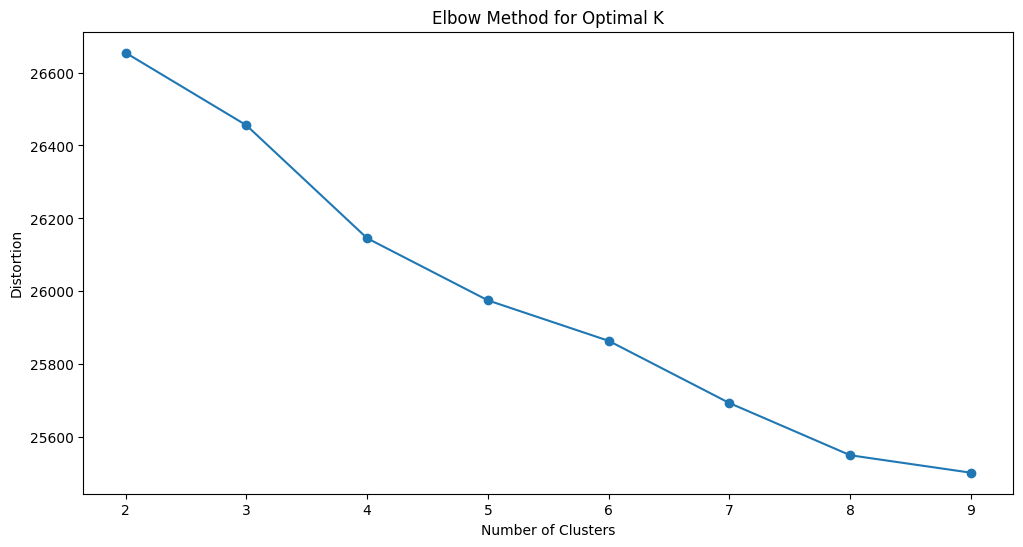

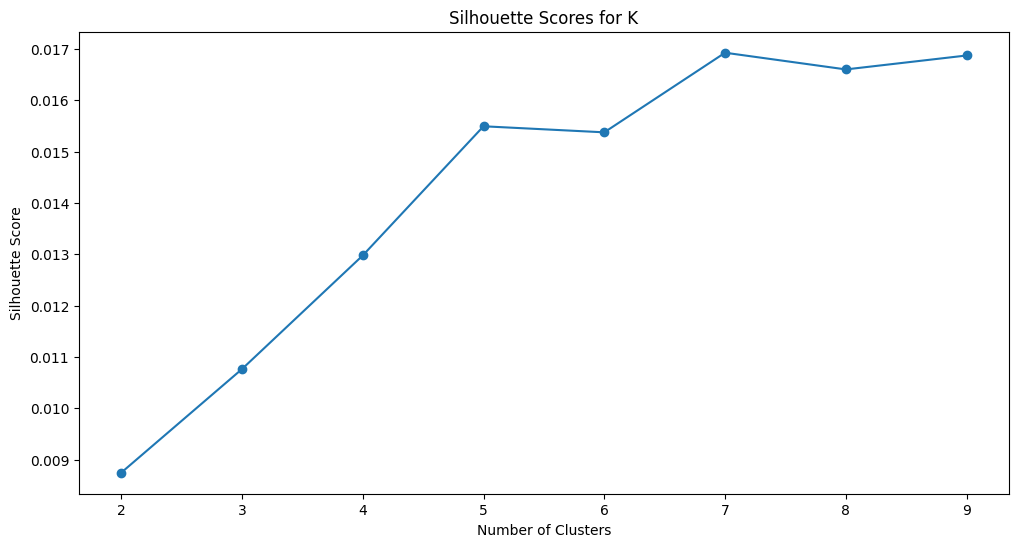

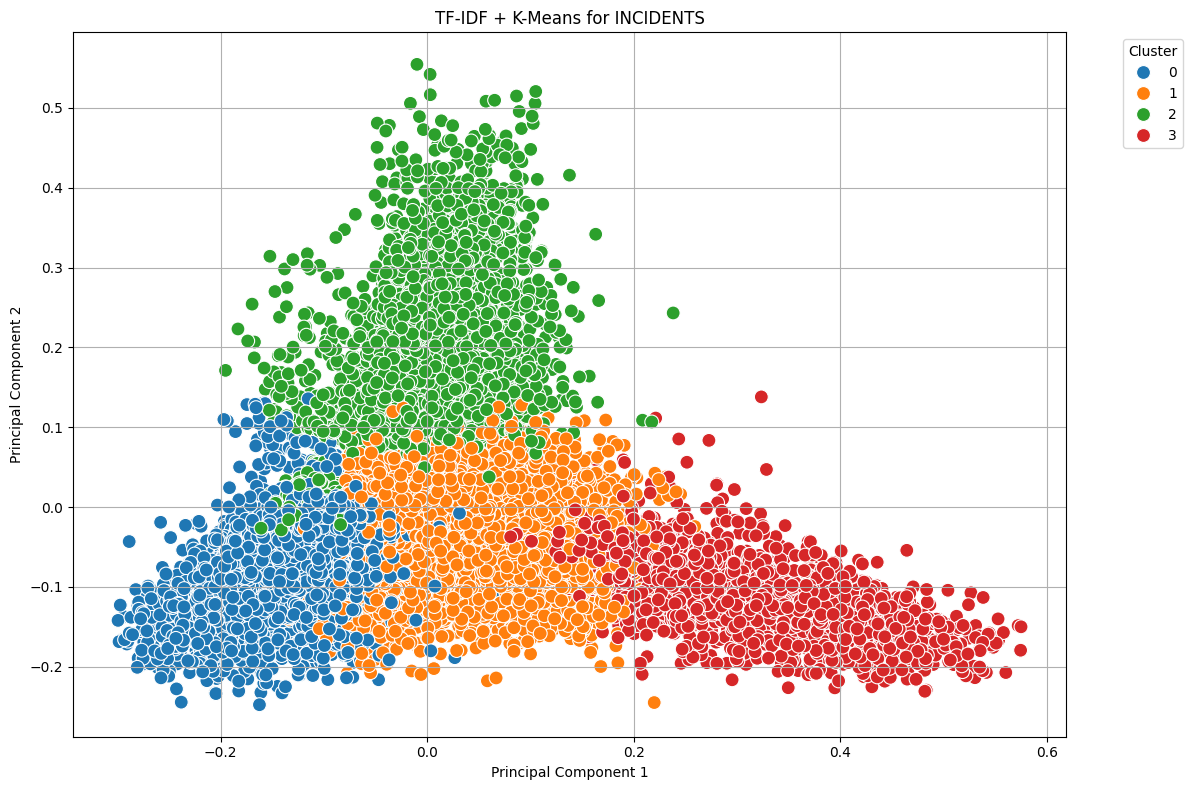

In [34]:
#Applying to INCIDENTS
df_filtered_incidents = tfidf_kmeans_clustering(df_filtered_incidents, "Processed_Summary")
visualize_kmeans_clusters(df_filtered_incidents, 
                          TfidfVectorizer(stop_words='english').fit_transform(df_filtered_incidents["Processed_Summary"]),
                           "TF-IDF + K-Means for INCIDENTS")

In [35]:
export_csv_result(df_filtered_accidents, "fullData_V2_ACCIDENTS_with_clusters")
export_csv_result(df_filtered_incidents, "fullData_V2_INCIDENTS_with_clusters")

File fullData_V2_ACCIDENTS_with_clusters.csv created in results
File fullData_V2_INCIDENTS_with_clusters.csv created in results


In [36]:
df_accidents = load_data_from_results("fullData_V2_ACCIDENTS_with_clusters.csv")
df_incidents = load_data_from_results("fullData_V2_INCIDENTS_with_clusters.csv")

## World Cloud for each cluster 

In [38]:
def process_clusters(df_param, cluster_column, label):
    word_frequencies_by_cluster = {}
    for i in range(NUMBER_OF_CLUSTERS):
        df_actual_cluster = df_param[df_param[cluster_column] == i]
        word_frequencies_by_cluster[i] = get_words_frequencies(df_actual_cluster)
        #export_csv_result(word_frequencies_by_cluster[i], f"Summary_word_frequencies_{label}_cluster{i}")
        
        # Display the first 10 rows
        print(f"CLUSTER {i} ({label})")
        print(word_frequencies_by_cluster[i].head(10))
        plotWordCloud(word_frequencies_by_cluster[i])
    return word_frequencies_by_cluster

### ACCIDENTS

File Summary_word_frequencies_ACCIDENTS_cluster0.csv created in results
CLUSTER 0 (ACCIDENTS)
          word  frequency
3845  helicopt       6569
5903     pilot       5132
6673     rotor       2975
4570      land       2161
2883     engin       1836
7645      tail       1651
3318    flight       1440
4884      main       1260
185   aircraft       1251
2312     damag       1188


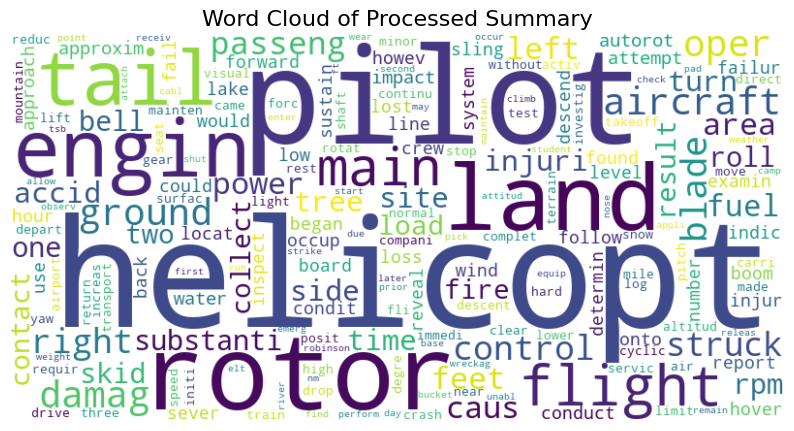

File Summary_word_frequencies_ACCIDENTS_cluster1.csv created in results
CLUSTER 1 (ACCIDENTS)
          word  frequency
2327      gear       6506
2921      land       5993
123   aircraft       4010
3783     pilot       2799
3465      nose       1919
4308    runway       1699
4241     right       1151
3106      main       1150
1259   collaps       1150
2964      left       1065


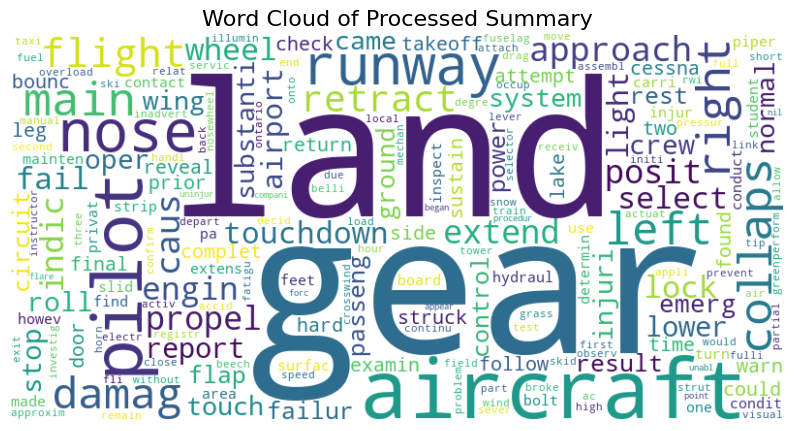

File Summary_word_frequencies_ACCIDENTS_cluster2.csv created in results
CLUSTER 2 (ACCIDENTS)
          word  frequency
190   aircraft      15105
6246     pilot       9492
6978    runway       9039
4962      land       6649
5030      left       4659
6862     right       3633
8854      wing       2502
2982     damag       2478
8834      wind       2407
2582   control       2237


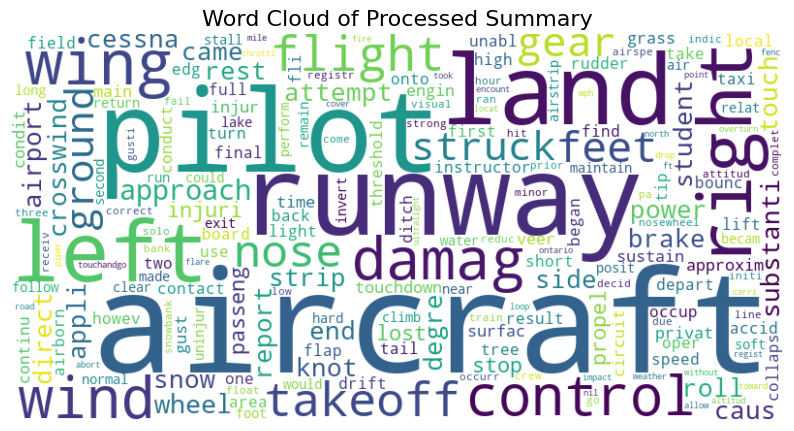

File Summary_word_frequencies_ACCIDENTS_cluster3.csv created in results
CLUSTER 3 (ACCIDENTS)
           word  frequency
406    aircraft      30282
14876     pilot      25048
7961      engin      10792
8735     flight      10181
11711      land      10021
9146       fuel       6302
15180     power       5269
6780      damag       4473
11867      left       4459
11671      lake       4238


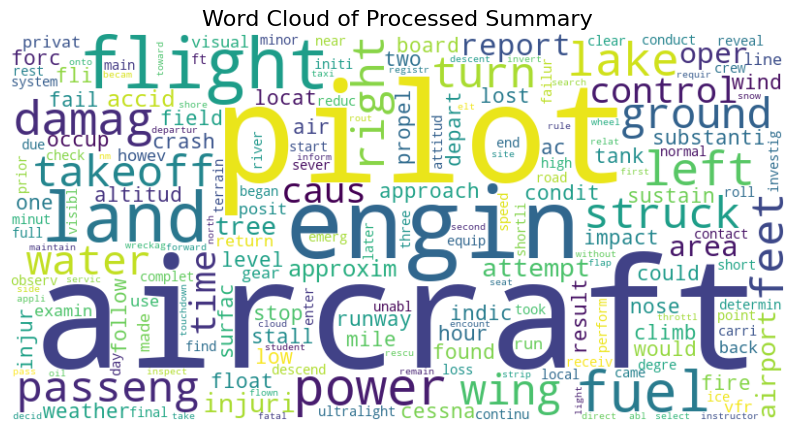

In [40]:
word_frequencies_accidents_by_cluster = process_clusters(df_accidents, "KMeansCluster", "ACCIDENTS")

### INCIDENTS  

File Summary_word_frequencies_INCIDENTS_cluster0.csv created in results
CLUSTER 0 (INCIDENTS)
           word  frequency
306    aircraft       9562
6022     flight       8365
5841       feet       7950
11094    runway       6993
4213    control       6434
11385     separ       5155
5974         fl       4523
9535       oper       4143
4355       crew       3978
3813      clear       3919


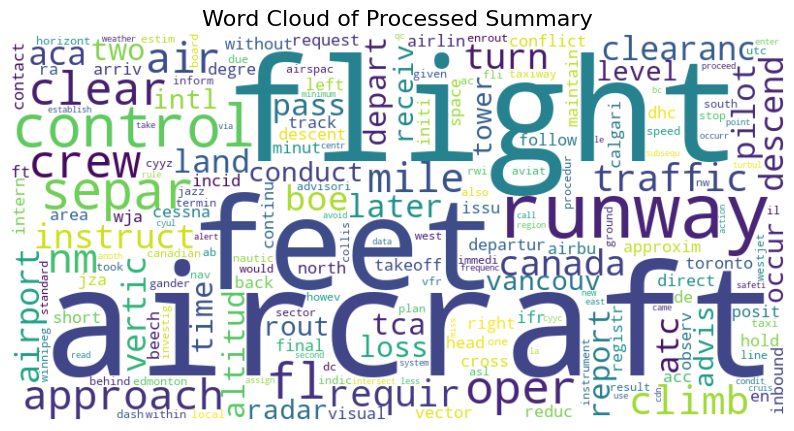

File Summary_word_frequencies_INCIDENTS_cluster1.csv created in results
CLUSTER 1 (INCIDENTS)
           word  frequency
7016     flight      24409
370    aircraft      23150
4750       crew      18408
9502       land      12235
11515      oper       9561
348         air       6781
13199    return       6775
10114   mainten       6176
6280      emerg       6093
5408     declar       5648


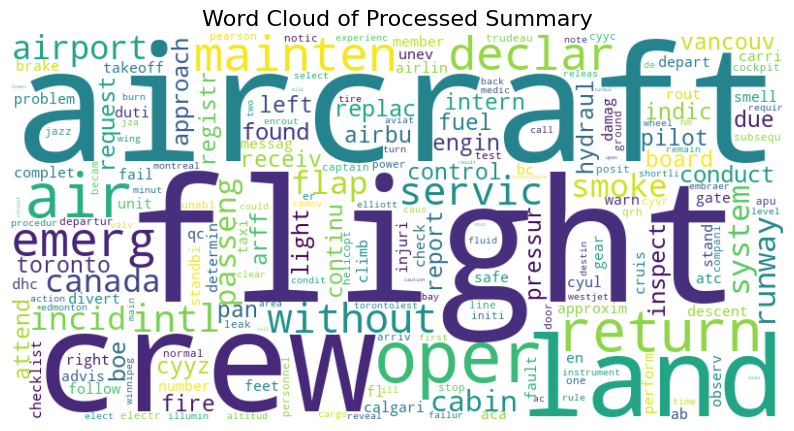

File Summary_word_frequencies_INCIDENTS_cluster2.csv created in results
CLUSTER 2 (INCIDENTS)
           word  frequency
5202      engin      15982
284    aircraft       7280
3613       crew       6446
5854     flight       6248
4159         de       4426
7693       land       4304
9405        oil       4273
7834         le       3785
11223    return       3454
8341    mainten       2873


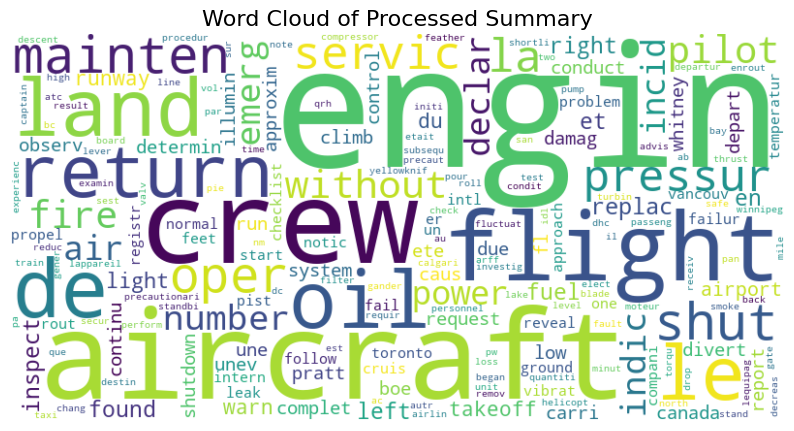

File Summary_word_frequencies_INCIDENTS_cluster3.csv created in results
CLUSTER 3 (INCIDENTS)
          word  frequency
2320      gear       8407
2917      land       6724
102   aircraft       3870
1438      crew       3654
2196    flight       2991
2632     indic       2014
3427      nose       1722
3095   mainten       1461
4134    return       1457
234   approach       1427


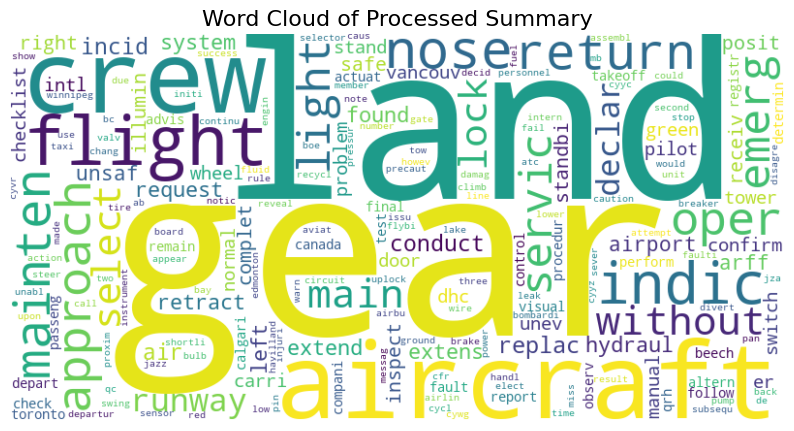

In [42]:
word_frequencies_incidents_by_cluster = process_clusters(df_incidents, "KMeansCluster", "INCIDENTS")